# Intro


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import hashlib

# Data Analysis

We load the original dataset to check its structure and data types. We can see there are no missing/null values and no rows that are duplicated entirely.

In [49]:
original_dataset = pd.read_csv("dataset_2025.csv")

# All anonymization processes will be done on this copy
dataset = original_dataset.copy()
duplicates = dataset.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}\n")

dataset.info()
dataset.head()


Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                150000 non-null  object 
 1   gender              150000 non-null  object 
 2   dob                 150000 non-null  object 
 3   postcode            150000 non-null  object 
 4   marital_status      150000 non-null  object 
 5   education           150000 non-null  object 
 6   employment          150000 non-null  object 
 7   num_children        150000 non-null  int64  
 8   home_ownership      150000 non-null  object 
 9   ethnicity           150000 non-null  object 
 10  income              150000 non-null  float64
 11  on_benefits         150000 non-null  bool   
 12  malnutrition_score  150000 non-null  float64
 13  disease             150000 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usa

name  gender         dob  postcode marital_status  \
0     James Taylor    male  24/10/1991  HX82 5XH        married   
1     Robert Smith    male  13/07/2011  TN46 9DG        married   
2  Elizabeth Smith  female  21/07/1959   RH3 3FH        widowed   
3      Linda Jones  female  24/09/2004  OX24 8NE         single   
4     David Taylor    male  26/09/2002   EH9 2YX       divorced   

               education  employment  num_children home_ownership  \
0               Bachelor     Student             6      Rent flat   
1               Bachelor     Retired             9     Rent house   
2                 PhD/md  Unemployed             0      Rent room   
3                Masters     Retired             0      Rent room   
4  Less than High School    Employed             7      Rent room   

          ethnicity    income  on_benefits  malnutrition_score  \
0  English-Scottish  14484.06        False               37.86   
1              Arab  26390.93        False               19.25   
2         Caribbean  21033.32        False               19.37   
3             Asian  30213.75        False               38.27   
4             other  42744.18        False               14.92   

           disease  
0    heart failure  
1  prostate cancer  
2    breast cancer  
3     tuberculosis  
4    endometriosis

In [24]:
# Check for duplicate identifiers
print("Number of people with duplicate names: ", dataset.duplicated(subset=["name"], keep=False).sum())
print("Number of people with duplicate names and dobs: ", dataset.duplicated(subset=["name", "dob"], keep=False).sum())
print("Number of people with the duplicate names, dobs, and postcodes: ", dataset.duplicated(subset=["name", "dob", "postcode"], keep=False).sum())

Number of people with duplicate names:  150000
Number of people with duplicate names and dobs:  21299
Number of people with the duplicate names, dobs, and postcodes:  0


### Original Distrbution

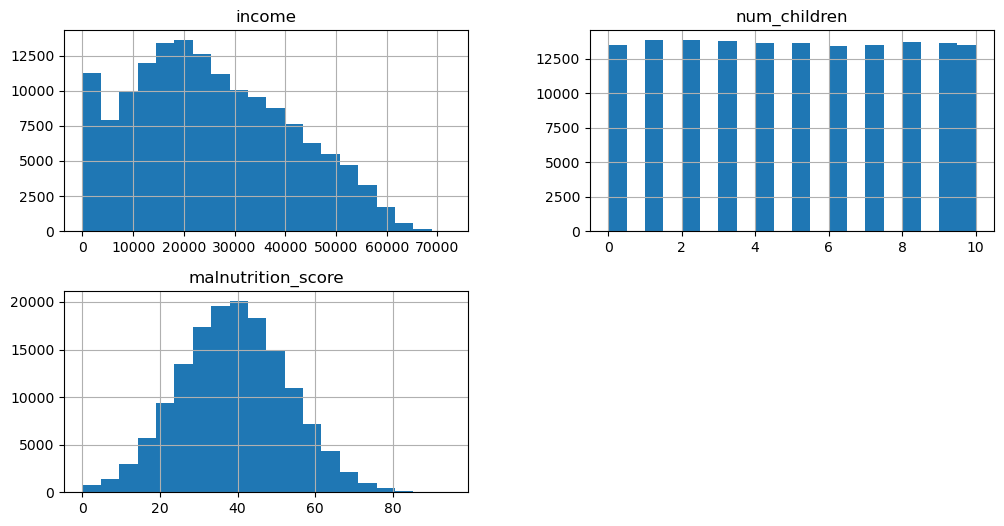

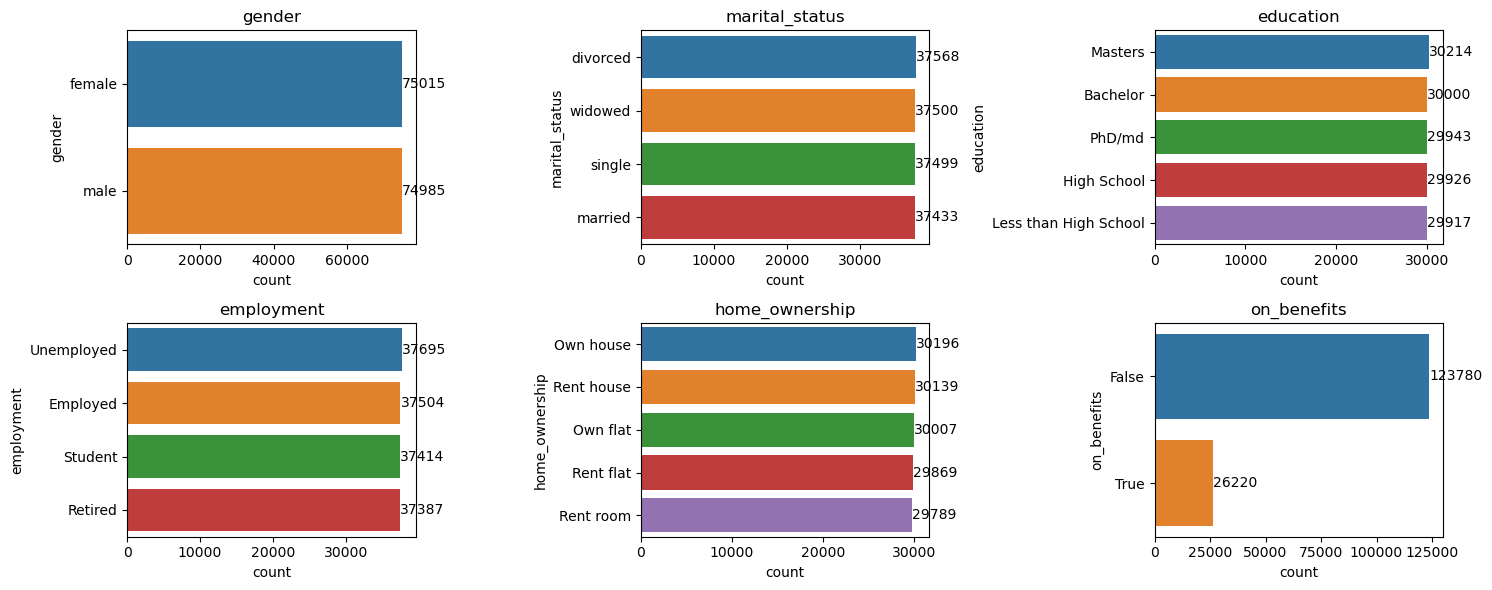

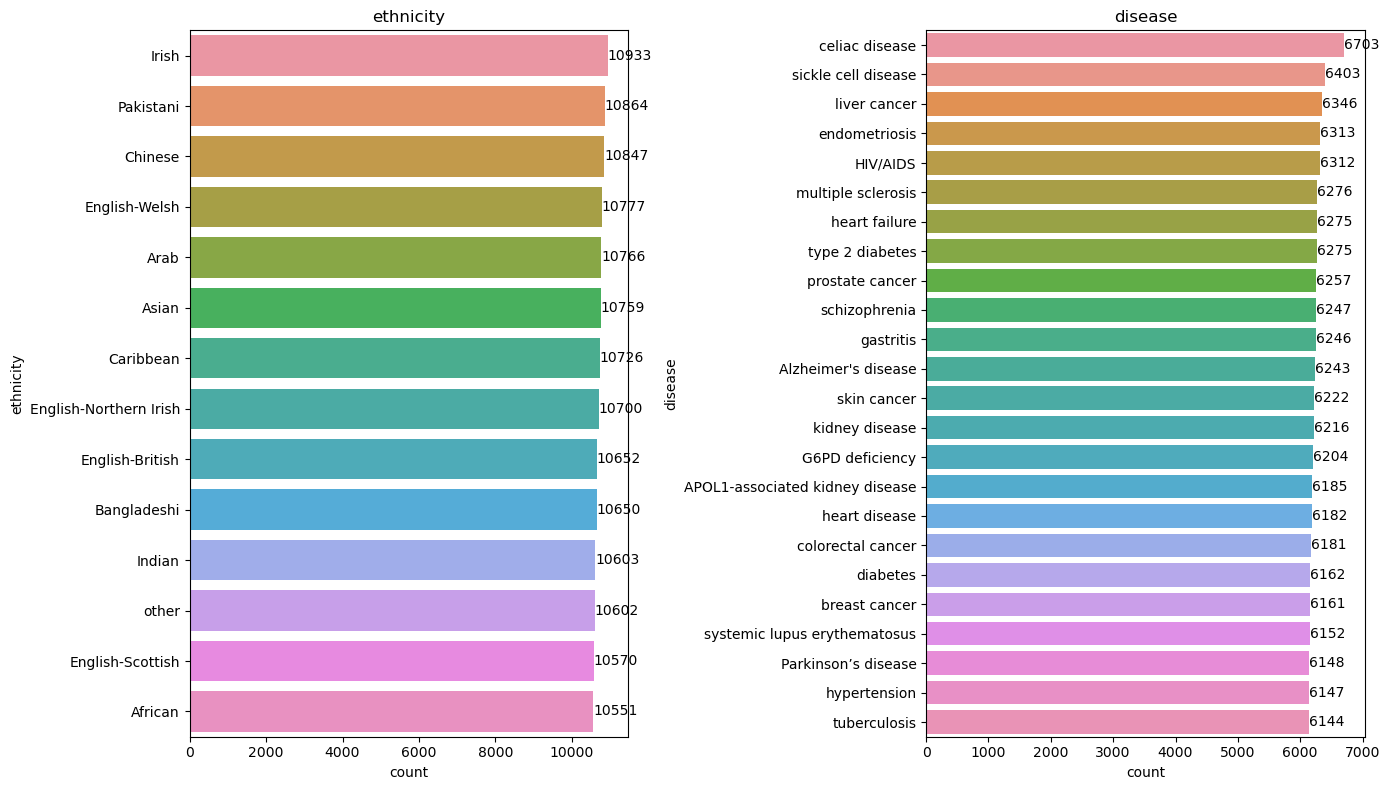

In [50]:
# numeric features
numeric_cols = ['income', 'num_children', 'malnutrition_score']
dataset[numeric_cols].hist(bins=20, figsize=(12,6))
plt.show()

# categorical features
categorical_cols_small = [
    'gender', 'marital_status', 'education', 'employment',
    'home_ownership', 'on_benefits'
]
categorical_cols_large = ['ethnicity', 'disease']

# small plots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, col in zip(axes.flat, categorical_cols_small):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)

    for p in ax.patches:
        count = int(p.get_width())  # bar length is the count for horizontal bars
        ax.text(p.get_width() + 0.1,               # x position (a bit past the bar)
                p.get_y() + p.get_height() / 2,    # y position (center of bar)
                f'{count}',                        # text
                va='center')                       # vertical alignment
        
plt.tight_layout()
plt.show()

# large plots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, col in zip(axes, categorical_cols_large):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)

    for p in ax.patches:
        count = int(p.get_width())  # bar length is the count for horizontal bars
        ax.text(p.get_width() + 0.1,               # x position (a bit past the bar)
                p.get_y() + p.get_height() / 2,    # y position (center of bar)
                f'{count}',                        # text
                va='center')                       # vertical alignment
plt.tight_layout()
plt.show()

# Use Cases

Must retain utility for analysis → these attributes will not be overly generalized.


Use Case 1: Ethnicity ↔ Disease

- Key attributes: `ethnicity`, `disease`


Use Case 2: Fairness in on_benefits Decision

- Key attributes: `income`, `gender`, `ethnicity`, `dob`
- should preserve distribution to detect bias


Use Case 3: Geographic + Qualifications ↔ Malnutrition

- Key attributes: `postcode`, `education`, `malnutrition_score`


# Attribute Categories

Direct identifiers

- `name` is unique for each row, should be removed entirely and just use a pseudoID.

Quasi-identifiers

- `gender`, `dob`, `postcode`, `ethnicity`, `employment`, `income` → can be used to re-identify individuals when combined; should be generalized or perturbed (benchmarking on effect on utility).

- `marital_status` and `home_ownership` could also act as quasi-identifiers depending on context.

Sensitive attributes

- `disease`, `malnutrition_score`, `on_benefits` → must be protected from inference attacks.

Non-sensitive attributes

- `education`, `num_children` → can be kept as-is or slightly generalized (e.g., grouping).

# Hashing


In [51]:
# Salt is a randomly generated string added to hashing input
salt = "h1wekchecp6ioncjhkgbauil2rioefnolcn8oiq[wqdwc]ev"

# Add a new hashed column to dataset as id 
hashing_input = dataset["name"] + dataset["dob"] + dataset["postcode"] + salt 
hashing_output = hashing_input.apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
dataset["id"] = hashing_output

# Display the first few rows of the updated dataset 
hashed_dataset = dataset.set_index("id")
hashed_dataset.head(5)

name  gender  \
id                                                                            
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...     James Taylor    male   
d413549638f33324d7874c199018a413153023f17f91d26...     Robert Smith    male   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...  Elizabeth Smith  female   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...      Linda Jones  female   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...     David Taylor    male   

                                                           dob  postcode  \
id                                                                         
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...  24/10/1991  HX82 5XH   
d413549638f33324d7874c199018a413153023f17f91d26...  13/07/2011  TN46 9DG   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...  21/07/1959   RH3 3FH   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...  24/09/2004  OX24 8NE   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...  26/09/2002   EH9 2YX   

                                                   marital_status  \
id                                                                  
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...        married   
d413549638f33324d7874c199018a413153023f17f91d26...        married   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...        widowed   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...         single   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...       divorced   

                                                                education  \
id                                                                          
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...               Bachelor   
d413549638f33324d7874c199018a413153023f17f91d26...               Bachelor   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...                 PhD/md   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...                Masters   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...  Less than High School   

                                                    employment  num_children  \
id                                                                             
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...     Student             6   
d413549638f33324d7874c199018a413153023f17f91d26...     Retired             9   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...  Unemployed             0   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...     Retired             0   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...    Employed             7   

                                                   home_ownership  \
id                                                                  
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...      Rent flat   
d413549638f33324d7874c199018a413153023f17f91d26...     Rent house   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...      Rent room   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...      Rent room   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...      Rent room   

                                                           ethnicity  \
id                                                                     
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...  English-Scottish   
d413549638f33324d7874c199018a413153023f17f91d26...              Arab   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...         Caribbean   
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430...             Asian   
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391...             other   

                                                      income  on_benefits  \
id                                                                          
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2...  14484.06        False   
d413549638f33324d7874c199018a413153023f17f91d26...  26390.93        False   
6a4af7a212cc91fa414f43810137f676f56349c98be01a5...  21033.32        False   
efc8f78ee308e9a6a

# Generalizing attributes

### Benchmark functions for utility

Helper functions that can be called after generalizing attributes to check our methods have not changed distribution drastically and affected utility.

1. Aim for high KS similarity for numerical features: `income`, `malnutrition_score`, ...
2. Same for Chi2 on categorial features: `gender`, `education`, `ethnicity`, `disease`, ...
3. Use correlation to test relationships have been preserved: `ethnicity` <-> `disease`, `income` <-> `on_benefits`

In [52]:
from scipy.stats import ks_2samp, chi2_contingency, pearsonr

# KS test for similarity of numeric distributions
# Return: 1.0 (identical) to 0.0 (completely different)
def ks_similarity(original, transformed):
    stat, p = ks_2samp(original, transformed)
    return 1 - stat

# Chi-squared test for similarity of categorical proportions
def chi2_similarity(original, transformed):
    o_counts = original.value_counts(normalize=True)
    t_counts = transformed.value_counts(normalize=True)
    common = o_counts.index.intersection(t_counts.index)
    if len(common) < 2: 
        return 0
    contingency = np.array([o_counts[common], t_counts[common]])
    chi2, p, _, _ = chi2_contingency(contingency)
    return min(1, p)

# Test similarity of correlation between two columns c1 and c2
def corr_similarity(original, transformed, c1, c2):
    def encode(s): return pd.factorize(s)[0] if s.dtype == 'object' else s
    o_corr = pearsonr(encode(original[c1]), encode(original[c2]))[0]
    t_corr = pearsonr(encode(transformed[c1]), encode(transformed[c2]))[0]
    return 1 - abs(o_corr - t_corr)


In [53]:
def benchmark_usecase1(original, transformed):
    print("Use Case 1: Ethnicity <-> Disease\n==========")
    sim_eth = chi2_similarity(original['ethnicity'], transformed['ethnicity'])
    sim_dis = chi2_similarity(original['disease'], transformed['disease'])
    sim_corr = corr_similarity(original, transformed, 'ethnicity', 'disease')

    print(f"Ethnicity distribution similarity: {sim_eth:.3f}")
    print(f"Disease distribution similarity:   {sim_dis:.3f}")
    print(f"Ethnicity–Disease correlation similarity: {sim_corr:.3f}")

    utility_score = (sim_eth + sim_dis + sim_corr) / 3
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [54]:
def benchmark_usecase2(original, transformed):
    print("Use Case 2: Fairness in on_benefits Decision\n==========")
    cols = ['income', 'gender', 'ethnicity', 'dob']
    sims = []

    # distribution similarity
    sims.append(ks_similarity(original['income'], transformed['income']))
    sims.append(chi2_similarity(original['gender'], transformed['gender']))
    sims.append(chi2_similarity(original['ethnicity'], transformed['ethnicity']))

    # correlations to on_benefits
    for c in ['income', 'gender', 'ethnicity']:
        sims.append(corr_similarity(original, transformed, c, 'on_benefits'))

    print(f"Distribution similarities: income={sims[0]:.3f}, gender={sims[1]:.3f}, ethnicity={sims[2]:.3f}")
    print(f"Correlation similarities: income↔on_benefits={sims[3]:.3f}, gender↔on_benefits={sims[4]:.3f}, ethnicity↔on_benefits={sims[5]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score

In [55]:
def benchmark_usecase3(original, transformed):
    print("Use Case 3: Geographic + Qualifications ↔ Malnutrition\n==========")
    sims = []

    # distribution similarities
    sims.append(chi2_similarity(original['postcode'], transformed['postcode']))
    sims.append(chi2_similarity(original['education'], transformed['education']))
    sims.append(ks_similarity(original['malnutrition_score'], transformed['malnutrition_score']))

    # correlation checks
    sims.append(corr_similarity(original, transformed, 'postcode', 'malnutrition_score'))
    sims.append(corr_similarity(original, transformed, 'education', 'malnutrition_score'))

    print(f"Distribution similarities: postcode={sims[0]:.3f}, education={sims[1]:.3f}, malnutrition={sims[2]:.3f}")
    print(f"Correlation similarities: postcode↔malnutrition={sims[3]:.3f}, education↔malnutrition={sims[4]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [56]:
def benchmark_all(original, transformed):
    print("=== Benchmarking All Use Cases ===")
    score1 = benchmark_usecase1(original, transformed)
    print()
    score2 = benchmark_usecase2(original, transformed)
    print()
    score3 = benchmark_usecase3(original, transformed)
    print("==================================")
    overall_score = (score1 + score2 + score3) / 3
    print(f"Overall Utility Score across all use cases: {overall_score:.3f}")
    return overall_score

## Benchmark functions for privacy

In [ ]:
# privacy metrics

# def get_valid_cols(dataset_, cols, verbose=False):
#     quasi = [col for col in cols if col in dataset_.columns]
#     if verbose:
#         print(f'Valid  quasi identifiers: {quasi}')
#     return quasi

# def get_valid_cols(original, anonymized, cols, verbose=False):
#     ori_quasi = [col for col in cols if col in original.columns]
#     anon_quasi = [col for col in cols if col in anonymized.columns]
#     valid_quasi = list(set(ori_quasi) & set(anon_quasi))
#     if verbose:
#         print(f'''Quasi identifiers in Original dataset: {ori_quasi}\n
#               Quasi ifentifiers in Anonymised dataset: {anon_quasi}''')
#         print(f'Valid overlapping set of quasi identifiers: {valid_quasi}')
#     return valid_quasi

def get_valid_cols(cols: list, original: pd.DataFrame, anonymized: pd.DataFrame=None, verbose=False):
    ori_cols = [col for col in cols if col in original.columns]

    if anonymized is not None:
        anon_cols = [col for col in cols if col in anonymized.columns]
        valid_cols = list(set(ori_cols) & set(anon_cols))
        if verbose:
            print(f"Quasi identifiers in Original dataset: {ori_cols}")
            print(f"Quasi identifiers in Anonymised dataset: {anon_cols}")
            print(f"Valid overlapping set of quasi identifiers: {valid_cols}")
    else:
        valid_cols = ori_cols
        if verbose:
            print(f"Valid quasi identifiers in dataset: {valid_cols}")

    return valid_cols


# higher entropy = more information = more utility 
def utility_entropy(dataset, quasi_identifiers):
    counts = dataset[quasi_identifiers].value_counts(normalize=True)
    return -np.sum(counts * np.log(counts))

def information_loss(original, anonymized, quasi_identifiers):
    valid_quasi = get_valid_cols(quasi_identifiers, original, anonymized)
    original_entropy = utility_entropy(original, valid_quasi)
    anonymized_entropy = utility_entropy(anonymized, valid_quasi)
    return original_entropy / anonymized_entropy

# returns group size k for given quasi-identifiers
# i.e. each combination of quasi-identifiers appears at least k times
def k_anonymity(dataset, quasi_identifiers):
    valid_quasi = get_valid_cols(quasi_identifiers, dataset)
    temp = dataset.dropna(subset=valid_quasi)
    group_sizes = temp.groupby(valid_quasi).size()
    k = group_sizes[group_sizes > 0].min()
    return k

# returns minimum number of distinct sensitive values in any equivalence class
def l_diversity(dataset, quasi_identifiers, sensitive_col):
    valid_quasi = get_valid_cols(quasi_identifiers, dataset)
    grouped = dataset.groupby(valid_quasi)[sensitive_col].nunique()
    l = grouped.min()
    return l

# Aim: check distribution of a sensitive attribute in each equivalence class is close to the overall distribution
# returns Earth Mover's Distance for each equivalence class
def t_closeness(dataset, quasi_identifiers, sensitive_attributes, t_threshold):
    result = {}
    all_emds = []

    for sensitive_attribute in sensitive_attributes:
         overall_dist = dataset[sensitive_attribute].value_counts(normalize=True)

         # Group by quasi-identifiers 
         grouped = dataset.groupby(quasi_identifiers)
         result[sensitive_attribute] = []

         for group_values, group_dataset in grouped:
            group_distance = group_dataset[sensitive_attribute].value_counts(normalize=True)
            
            # Align both distributions for Earth Mover's Distance calculation
            all_values = list(set(overall_dist.index).union(set(group_distance.index)))
            g_global = overall_dist.reindex(all_values, fill_value=0)
            g_group = group_distance.reindex(all_values, fill_value=0)

            # Compute Earth Mover's Distance
            emd = np.sum(np.abs(np.cumsum(g_group - g_global)))
            all_emds.append(emd)

            result[sensitive_attribute].append({
                "group value": group_values,
                "distance": emd,
                "within t threshold": emd <= t_threshold
            })
            
    # overall t closeness
    maximum_emd = max(all_emds)

    return {
        "overall t closeness": maximum_emd <= t_threshold,
        "max emd": maximum_emd,
        "details": result  
    }



In [ ]:
QUASI_IDS = [
    'gender', 'age', 'postcode'
]
# 'ethnicity', 'employment', 'income'
SENSITIVE_ATTRS = ['disease', 'malnutrition_score', 'on_benefits']
# OPTIONAL_QUASI_IDS = ['marital_status', 'home_ownership']
T_THRESHOLD = 0.2  

# runs all the helper functions above to check privacy metrics
def check_privacy(original_dataset, dataset, quasi_identifiers=QUASI_IDS, sensitive_cols=SENSITIVE_ATTRS):
    report = {}
    
    # per column
    report['information loss'] = information_loss(original_dataset, dataset, quasi_identifiers)
    
    report['k_anonymity'] = k_anonymity(dataset, quasi_identifiers)
    
    # per sensitive column
    report['l_diversity'] = {col: l_diversity(dataset, quasi_identifiers, col) for col in sensitive_cols}
    report['t_closeness'] = t_closeness(dataset, quasi_identifiers, sensitive_cols, T_THRESHOLD)
    
    print("=== Privacy Metrics ===")
    print(f"Information Loss (quasi-identifiers) from original dataset to anonymized dataset: {report['information loss']:.3f}")
    print(f"k-anonymity (min group size): {report['k_anonymity']}")
    print(f"l-diversity per sensitive column:")
    for col, l in report['l_diversity'].items():
        print(f"  {col}: {l}")
    print(f"t-closeness of datas:", report['t_closeness']["overall t closeness"])
    print(f"max Earth Mover's Distance of dataset:", report['t_closeness']["max emd"])
    for col, detail in report['t_closeness']["details"].items():
        print(f"Details for sensitive attribute: {col}")
        for entry in detail:
            print(f"  Group Value: {entry['group value']}, Distance: {entry['distance']:.3f}, Within t threshold: {entry['within t threshold']}")


# Suppression

### Dropping columns

Although `name` is not unique in this dataset (the least duplicated at 2924 entries), it is still information that could be used to identify someone and does not affect utility at all. Thus we drop it.

In [59]:
print(f"Number of unique names: {dataset['name'].nunique()}")
name_counts = dataset['name'].value_counts(ascending=True)
print(name_counts.head(2))

dataset.drop(columns=['name'], inplace=True)
print("\nDropped 'name' column.")

Number of unique names: 50
name
Barbara Jones    2924
Robert Brown     2924
Name: count, dtype: int64

Dropped 'name' column.


In [60]:
#test run benchmark functions
benchmark_all(dataset, dataset)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 1.000
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000
→ Overall utility score: 1.000

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=1.000
→ Overall utility score: 1.000
Overall Utility Score across all use cases: 1.000


1.0

## Dropping Rows

### DOB to Age Translation

We first transform the 'dob' column to 'age', and perform generalization by categorising age values into buckets. <br>
Use 31 Oct 2025 as reference data

In [61]:
from datetime import datetime

ref_date = datetime(2025, 10, 31)

# Convert dob column to datetime (if not already)
dataset['dob'] = pd.to_datetime(dataset['dob'], format='%d/%m/%Y', errors='coerce')
dataset['age'] = (
    ref_date.year - dataset['dob'].dt.year
    - ((ref_date.month < dataset['dob'].dt.month) |
       ((ref_date.month == dataset['dob'].dt.month) & (ref_date.day < dataset['dob'].dt.day)))
)

### Drop rows which are insensible or impractical

In [62]:
# Age & Num of children
# Removes rows where person is below 16 but has 4 or more children
dataset = dataset.drop(
    dataset[
        (dataset['num_children'] >= 4) & 
        (dataset['age'] < 16)
    ].index
)
# Removes rows where person is 16-25 (inclusive) but has 7 or more children
dataset = dataset.drop(
    dataset[
        (dataset['num_children'] >= 7) & 
        (dataset['age'] < 25)
    ].index
)

# Age & Employment
# Removes rows where person is below 16 years old but is considered unemployed or retired
dataset = dataset.drop(
    dataset[
        (dataset['employment'].isin(['Unemployed', 'Retired'])) & 
        (dataset['age'] < 16)
    ].index
)

# Remove rows where Disease and Gender are incompatible 
# dataset = dataset.drop(
#     dataset[
#         (dataset['disease'] == 'breast cancer') & 
#         (dataset['gender'] == 'male')
#     ].index
# )

dataset = dataset.drop(
    dataset[
        (dataset['disease'] == 'prostate cancer') & 
        (dataset['gender'] == 'female')
    ].index
)

dataset = dataset.drop(
    dataset[
        (dataset['disease'] == 'endometriosis') & 
        (dataset['gender'] == 'male')
    ].index
)


# Age & Marital status
# Removes rows where person is below 16 (legal age for marriage in UK) but not single
dataset = dataset.drop(
    dataset[
        (dataset['marital_status'].isin(['married', 'divorced', 'widowed'])) & 
        (dataset['age'] < 16)
    ].index
)

# Age & Education
# Removes rows where person is 16 or below but has education beyong high school
dataset = dataset.drop(
    dataset[
        (dataset['education'].isin(['Masters', 'Bachelor', 'PhD/md'])) & 
        (dataset['age'] <= 16)
    ].index
)

# Income & Benefits
# Removes rows where person has income above 50k but on benefits
dataset = dataset.drop(
    dataset[
        (dataset['on_benefits'] == True) & 
        (dataset['income'] > 50000)
    ].index
)

print('Shape of dataset after removing impractical records: ', dataset.shape)

Shape of dataset after removing impractical records:  (126716, 15)


# Generalisation

### Age

In [63]:
print("Min age: ", dataset['age'].min())
print("Max age: ", dataset['age'].max())

# age_bins = [x for x in range(10, 71, 5)]
# age_bins = [10, 15, 20, 30, 40, 50, 60, 70]
# age_bins = [10, 16, 21, 30, 40, 50, 60, 70]
age_bins = [10, 16, 25, 35, 45, 55, 70]
print(age_bins)

# Sort age into bins 
# dataset['age'] = pd.cut(dataset['age'], age_bins, labels=["11-15", "16-20", "21-25", "26-30", "31-35", "36-40", "41-45", "46-50", "51-55", "56-60", "61-65", "66-70"])
# dataset['age'] = pd.cut(dataset['age'], age_bins, labels=["11-15", "16-20", "21-30", "31-40", "41-50", "51-60", "61-70"])
dataset['age'] = pd.cut(dataset['age'], age_bins, labels=["11-16", "17-25", "26-35", "36-45", "46-55", "56-70"])

Min age:  12
Max age:  70
[10, 16, 25, 35, 45, 55, 70]


### Income

In [64]:
print("Min income: ", dataset['income'].min())
print("Max income: ", dataset['income'].max())

#income_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000]
#income_bins = [0, 20000, 40000, 60000, 80000]
income_bins = [0, 12000, 50000, 80000]
dataset['income'] = pd.cut(dataset['income'], income_bins, labels=["0-12000", 
                                                                   "12000-50000",
                                                                   ">50000"], include_lowest=True)

Min income:  0.0
Max income:  72479.86


### Postcode

In [65]:
regex = '([a-zA-Z ]*)\d*.*'
dataset['postcode'] = dataset['postcode'].str.split(' ').str[0].str.extract(regex)

### Number of children

In [ ]:
num_children_bins = [-1, 0, 3, 6, 10]
dataset['num_children'] = pd.cut(dataset['num_children'], num_children_bins, labels=["0", "1-3", "4-6", "7-10"], right=True, include_lowest=True)




### Education

In [ ]:
dataset.loc[dataset['education'].isin(['Masters', 'PhD/md', 'Bachelor']), 'education'] = 'Degree' 

### Employment

In [ ]:
dataset.loc[dataset['employment'].isin(['Unemployed', 'Student', 'Retired']), 'employment'] = 'Non-working'

### Ethnicity

In [ ]:
dataset.loc[dataset['ethnicity'].isin(['English-British', 'English-Northern Irish', 'English-Welsh', 'English-Scottish']), 'ethnicity'] = 'English' 
dataset.loc[dataset['ethnicity'].isin(['Pakistani', 'Chinese', 'Asian', 'Bangladeshi', 'Indian']), 'ethnicity'] = 'Asian'

In [67]:
def get_equivalence_class_sizes(dataset):
    groups = dataset.groupby(['gender', 'age', 'postcode', 'ethnicity', 'education', 'employment'])
    # print(groups.filter(lambda x: len(x) == 1))
    return [len(g[1]) for g in groups]

def plot_equivalence_graph(dataset):
    equivalence_sizes = get_equivalence_class_sizes(dataset)
    print("Min class size: ", min(equivalence_sizes))
    plt.figure(figsize=(15,10))
    a = plt.hist(equivalence_sizes, bins=np.arange(1, max(equivalence_sizes)+2, 1), align='left', width=.9)
    print(a[0])
    print(sum(a[0]))
    plt.xlabel("Size of Equivalence Classes") 
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")

/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/3754869683.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dataset.groupby(['gender', 'age', 'postcode', 'ethnicity', 'education', 'employment'])


Min class size:  2
[0.000e+00 7.299e+03 4.477e+03 2.892e+03 1.978e+03 1.434e+03 1.024e+03
 6.530e+02 4.790e+02 3.560e+02 3.110e+02 2.460e+02 1.970e+02 1.930e+02
 1.560e+02 1.560e+02 1.700e+02 1.360e+02 1.060e+02 9.600e+01 7.800e+01
 7.600e+01 4.900e+01 4.300e+01 3.700e+01 1.700e+01 3.200e+01 2.000e+01
 1.100e+01 1.100e+01 1.200e+01 4.000e+00 2.000e+00 2.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.000e+00]
22756.0


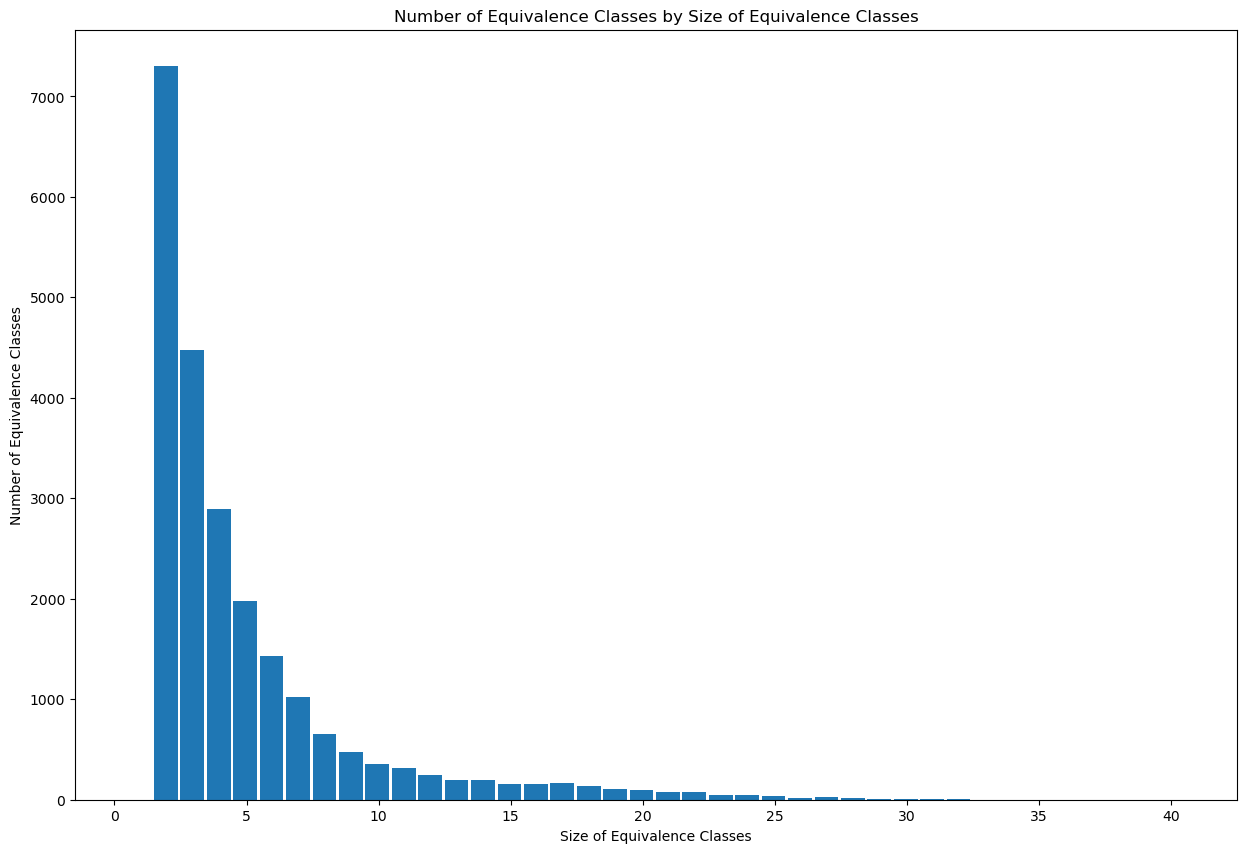

In [79]:
# k_anonymity(dataset, quasi_identifiers=QUASI_IDS)
#print(dataset.count())
plot_equivalence_graph(dataset)
# check_privacy(original_dataset, dataset) # TODO: fix check_privacy function

# Remove records with equivalence class of size 1.


In [69]:
def drop_unique_equivalence_classes(dataset, min_size=2):
	# Define the quasi-identifiers
	quasi_identifiers = ['gender', 'age', 'postcode', 'ethnicity', 'education', 'employment']

	# Compute equivalence class sizes for each row
	dataset['eq_class_size'] = dataset.groupby(quasi_identifiers)['gender'].transform('size')

	# Keep only rows where equivalence class size > 1
	dataset = dataset[dataset['eq_class_size'] >= min_size]

	# Drop the helper column if you don’t need it
	dataset = dataset.drop(columns='eq_class_size')

	return dataset


In [70]:
dataset = drop_unique_equivalence_classes(dataset, 2)
print("Shape of dataset after dropping rows of equivalence class size = 1: ",dataset.shape)

/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/3500227595.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset['eq_class_size'] = dataset.groupby(quasi_identifiers)['gender'].transform('size')


In [103]:
k_anonymity(dataset, ['gender', 'age', 'postcode', 'ethnicity', 'education', 'employment'])


/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/765848150.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = temp.groupby(valid_quasi).size()


2

In [117]:
check_privacy(original_dataset, dataset, quasi_identifiers=['gender', 'age', 'postcode', 'ethnicity', 'education', 'employment'])

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/3839142686.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = temp.groupby(valid_quasi).size()
/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/3839142686.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dataset.groupby(valid_quasi)[sensitive_col].nunique()
/var/folders/bb/p6m9qrzd7lzclcj5b7v_c__c0000gn/T/ipykernel_73316/3839142686.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior

=== Privacy Metrics ===
Information Loss (quasi-identifiers) from original dataset to anonymized dataset: 1.415
k-anonymity (min group size): 2
l-diversity per sensitive column:
  disease: 0
  malnutrition_score: 0
  on_benefits: 0
t-closeness of datas: False
max Earth Mover's Distance of dataset: 3685.816376135038
Details for sensitive attribute: disease
  Group Value: ('female', '11-16', 'AL', 'English', 'High School', 'Employed'), Distance: 4.271, Within t threshold: False
  Group Value: ('female', '11-16', 'BA', 'Asian', 'High School', 'Non-working'), Distance: 3.432, Within t threshold: False
  Group Value: ('female', '11-16', 'BA', 'English', 'Less than High School', 'Non-working'), Distance: 8.929, Within t threshold: False
  Group Value: ('female', '11-16', 'BH', 'Asian', 'High School', 'Non-working'), Distance: 3.172, Within t threshold: False
  Group Value: ('female', '11-16', 'CF', 'Arab', 'Less than High School', 'Non-working'), Distance: 3.933, Within t threshold: False
  

In [ ]:
def l_diversity(dataset, quasi_identifiers, sensitive_col):
    grouped = dataset.groupby(quasi_identifiers)[sensitive_col].nunique()
    l = grouped.min()
    return l

ethnicity
English        34759
Irish           8939
Pakistani       8884
Chinese         8866
Arab            8826
Caribbean       8802
Asian           8774
Bangladeshi     8774
Indian          8695
other           8663
African         8589
Name: count, dtype: int64